In [8]:
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import signal
import seaborn as sns
from scipy.fft import fft
from matplotlib import collections as matcoll
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.preprocessing import normalize
from progressbar import *
from functools import reduce
import gc
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import socketio
import eventlet
import eventlet.wsgi
from flask import Flask
import base64
from numpy import genfromtxt
import time
import random
from scipy import stats

In [9]:
#The modula for visual processing
class retina_parallel():
    def __init__(self, l_name, r_name, F_size=[20,20], _S=15):
        self.gl = self.retina_image(l_name)
        self.gr = self.retina_image(r_name)
        self.N = self.gl.shape[0]
        self.L = self.gl.shape[1]
        self.Fw = F_size[0]
        self.Fh = F_size[1]
        self.S = _S
        self.Pl = self.Fw - 1
        self.Pn = self.Fh - self.N%self.S
        self.Ph = int(self.N/self.S)
    #Transfer the image to gray scale
    def retina_image(self, name):
        img = cv2.imread(name)
        img_lum = 0.2126*img[:,:,0] + 0.7152*img[:,:,1] + 0.0722*img[:,:,2]
        return img_lum   
    #Return the spatial-frequency responses
    def premap(self,_ip0,_ip1,_ip2,_ip3,_im0,_im1,_N,_Pl,_Pn,_L,_pmap_e,_g):
        pmap = np.concatenate((_g,np.zeros((_N,_Pl))),axis=1)
        pmap = np.concatenate((pmap,np.zeros((_Pn,_L+_Pl))),axis=0)
        _pmap_e[_ip0,_ip1,_ip2,_ip3] = pmap[_im0,_im1]
        return np.fft.fftn(_pmap_e, axes=(2, 3,)) 
    #Binocular correspondence
    def compmap(self,map_l,map_r,_L):
        paired = {}
        for i in range(_L):
            paired[i]='y'

        pair_r = np.zeros(_L)
        for i in range(_L):
            min_r = np.sum(np.abs(map_l[i,:,:]-map_r[0,:,:]))
            min_jr = 0
            for j in range(_L):
                if paired[j] == 'y':
                    cmp = np.sum(np.abs(map_l[i,:,:]-map_r[j,:,:]))
                    if cmp<=min_r:
                        min_r = cmp
                        min_jr = j
            pair_r[i] = min_jr
            paired[min_jr] = 'n'
        return pair_r    
    #Define equations of Ding-Sperling model
    def diff_a(self,l):
        return np.hstack((np.diff(l),np.array([0])))
    
    def sf_filter_i(self,d):
        l = np.array(range(200))
        return -(1-np.square(l)/np.square(d))*np.exp(-0.5*np.square(l)/np.square(d))/(np.pi*np.square(d))
    
    def w_lum_c(self,l):
        r0 = 0.1*l/180
        l = np.array(range(l))
        return 1/(1+np.square(l)/np.square(r0))

    def lum_sum_w(self,row):    
        bi = 1
        k = 1
        I = row
        I0 = np.sum(I)
        cx = self.diff_a(self.diff_a(I))/I0
        eri = []
        for di in np.arange(5,50,5):
            logi = self.sf_filter_i(di)
            c = np.convolve(I,logi)/I0
            er = bi*np.sum(c*self.w_lum_c(len(c)))
            eri.append(er)
        E = sum(eri)
        L = k*np.sum(I*self.w_lum_c(len(I)))
        return E*L
    #Target detection at the begining of the trial when the end-effector is not visible 
    def find_one(self,c,d):
        csf = np.array([[0,0,0.5,0,0],[0,0,1,0,0],[0.5,1,-6,1,0.5],[0,0,1,0,0],[0,0,0.5,0,0]])
        o = np.zeros((c.shape[0],c.shape[1]))
        _c = np.concatenate((c,np.zeros((c.shape[0],4))),axis=1)
        _c = np.concatenate((_c,np.zeros((4,_c.shape[1]))),axis=0)
        for i in range(o.shape[0]):
            for j in range(o.shape[1]):
                o[i,j] = np.sum(_c[i:i+5,j:j+5]*csf)
        o = o.astype(np.uint8)
        g = cv2.GaussianBlur(o, (5, 5), 0)
        g[g<130]=0
        k=5
        ki = g.shape[0]-k
        kj = g.shape[1]-k
        o2 = []
        for i in range(ki):
            for j in range(kj):
                zone = g[i:i+k,j:j+k]
                pos = np.where(zone>0)
                if len(pos[1])>0:
                    px = int(np.mean(pos[0]))+i
                    py = int(np.mean(pos[1]))+j
                    if np.mean(zone)>=100:
                        o2.append([px,py]) 
        o2 = np.array(o2)
        o2 = np.mean(o2,axis=0)
        return np.array([int(o2[0]),int(o2[1]),d[int(o2[0]),int(o2[1])]])
    #Localization of the target and the end-effector
    def find_two(self,c,d,ppos):
        csf = np.array([[0,0,0.5,0,0],[0,0,1,0,0],[0.5,1,-6,1,0.5],[0,0,1,0,0],[0,0,0.5,0,0]])
        o = np.zeros((c.shape[0],c.shape[1]))
        _c = np.concatenate((c,np.zeros((c.shape[0],4))),axis=1)
        _c = np.concatenate((_c,np.zeros((4,_c.shape[1]))),axis=0)
        for i in range(o.shape[0]):
            for j in range(o.shape[1]):
                o[i,j] = np.sum(_c[i:i+5,j:j+5]*csf)
        o = o.astype(np.uint8)
        g = cv2.GaussianBlur(o, (5, 5), 0)
        g[g<130]=0
        k=5
        ki = g.shape[0]-k
        kj = g.shape[1]-k
        o2 = []
        for i in range(ki):
            for j in range(kj):
                zone = g[i:i+k,j:j+k]
                pos = np.where(zone>0)
                if len(pos[1])>0:
                    px = int(np.mean(pos[0]))+i
                    py = int(np.mean(pos[1]))+j
                    if np.mean(zone)>=100:
                        o2.append([px,py]) 
        o2 = np.array(o2)
        kmodel = KMeans(n_clusters = 2, max_iter=500) 
        kmodel.fit(o2)
        of = np.array([int(ppos[0]),int(ppos[1])])
        r = kmodel.cluster_centers_
        lbs = list(kmodel.labels_)
        if sum(lbs)<0.2*len(lbs):
            o3 = []
            for i in range(o2.shape[0]):
                if np.linalg.norm(o2[i]-r[0])<70:
                    o3.append(o2[i])
            o3 = np.array(o3)   
            kmodel = KMeans(n_clusters = 2, max_iter=500) 
            kmodel.fit(o3)
            r = kmodel.cluster_centers_      
        elif sum(lbs)>0.8*len(lbs):
            o3 = []
            for i in range(o2.shape[0]):
                if np.linalg.norm(o2[i]-r[1])<70:
                    o3.append(o2[i])
            o3 = np.array(o3)   
            kmodel = KMeans(n_clusters = 2, max_iter=500) 
            kmodel.fit(o3)
            r = kmodel.cluster_centers_
      
        if np.linalg.norm(r[0]-of) < np.linalg.norm(r[1]-of):
            return np.array([int(r[0][0]),int(r[0][1]),d[int(r[0][0]),int(r[0][1])]]),np.array([int(r[1][0]),int(r[1][1]),d[int(r[1][0]),int(r[1][1])]])
        else:
            return np.array([int(r[1][0]),int(r[1][1]),d[int(r[1][0]),int(r[1][1])]]),np.array([int(r[0][0]),int(r[0][1]),d[int(r[0][0]),int(r[0][1])]])
    #Mark an location with small white circle
    def mark(self,img,pos,text):
        cv2.rectangle(img,(int(pos[1]-5),int(pos[0]-5)),(int(pos[1]+5),int(pos[0]+5)),(255,0,0),3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, text, (int(pos[1]+5),int(pos[0]+5)), font, 0.5, (255,0,0), 1)
        return img

    def main(self):
        ip0 = reduce(lambda x, y:x+y, [[i]*self.Fw*self.Fh for i in range(self.L)])*self.Ph
        ip1 = reduce(lambda x, y:x+y, [[i]*self.Fw*self.Fh*self.L for i in range(self.Ph)])
        ip2 = reduce(lambda x, y:x+y, [[i]*self.Fw for i in range(self.Fh)])*self.L*self.Ph
        ip3 = list(range(self.Fw))*self.L*self.Ph*self.Fh
        im0 = np.array(ip2) + np.array(reduce(lambda x, y:x+y, [[i*self.S]*self.L*self.Fh*self.Fw for i in range(self.Ph)]))
        im1 = reduce(lambda x, y:x+y, [list(range(i,self.Fw+i))*self.Fh for i in range(self.L)])*self.Ph
        pmap_ept = np.zeros((self.L,self.Ph,self.Fh,self.Fw))
        lmap = self.premap(ip0,ip1,ip2,ip3,im0,im1,self.N,self.Pl,self.Pn,self.L,pmap_ept,self.gl)
        rmap = self.premap(ip0,ip1,ip2,ip3,im0,im1,self.N,self.Pl,self.Pn,self.L,pmap_ept,self.gr)
        del ip0,ip1,ip2,ip3,im0,im1,pmap_ept
        gc.collect()
        c_image = np.zeros((self.N,self.L))
        d_image = np.zeros((self.N,self.L))
        
       # widgets = ['Progress: ',Percentage(), ' ', Bar('#'),' ', Timer(),
        #   ' ', ETA(), ' ', FileTransferSpeed()]
        #pbar = ProgressBar(widgets=widgets, maxval=10*self.Ph).start()

        for i in range(self.Ph):
         #   pbar.update(10 * i + 1)
            pr = self.compmap(lmap[:,i,:,:],rmap[:,i,:,:],self.L)
            pr = pr.astype(int)
            wl = []
            wr = []
            dpth = []
            for j in range(self.L):    
                ell = self.lum_sum_w(self.gl[:,j])
                elr = self.lum_sum_w(self.gr[:,pr[j]])
                wl.append(ell/(ell+elr))
                wr.append(elr/(ell+elr))
                _min = min(self.L-j,pr[j])
                _max = max(self.L-j,pr[j])
                dpth.append(1.414*_min+(_max-_min)/1.414)
            c_image[i*self.S:i*self.S+self.S,range(self.L)] = wl*self.gl[i*self.S:i*self.S+self.S,range(self.L)]+wr*self.gr[i*self.S:i*self.S+self.S,pr]  
            d_image[i*self.S:i*self.S+self.S,range(self.L)] = np.array([dpth]).repeat(self.S,axis=0)
        #pbar.finish()    
        c_image[self.Ph*self.S:,range(self.L)] = self.gl[self.Ph*self.S:,range(self.L)] 
        return c_image.astype(np.uint8),d_image



In [4]:
#extract the position information from all the training images
rt = []
widgets = ['Progress: ',Percentage(), ' ', Bar('#'),' ', Timer(),
           ' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=10*5400).start()
for i in range(5400):
    pbar.update(10 * (i-0) + 1)
    pro = retina_parallel('./test_pic_m2/'+str(i)+'l.png','./test_pic_m2/'+str(i)+'r.png')
    c,d = pro.main()
    pos = pro.find_one(c,d)
    rt.append(pos)
pbar.finish()  

Progress: 100% || Elapsed Time: 1 day, 12:26:00 Time: 1 day, 12:26:00   0.4 B/s


In [5]:
np.savetxt('move_m2',np.array(rt))

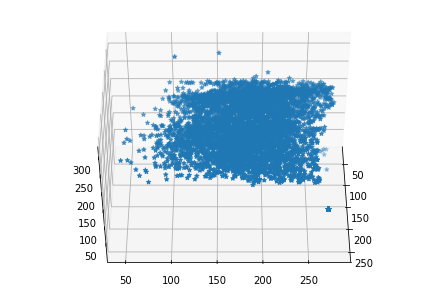

In [7]:
#show all the sampled locations during training
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(rt[:,0],rt[:,1],rt[:,2],marker="*")



ax.view_init(elev=45., azim=0.)

plt.show()

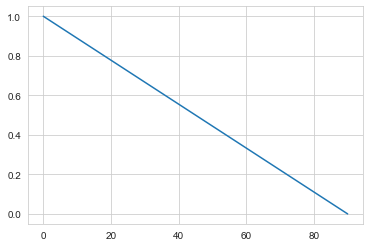

In [8]:
#plot the tunning curve
x = np.array(list(range(180)))
x[x>90]=90
y = 1-x/90
#y=np.exp(-0.001*x**2)
plt.plot(x,y)

In [18]:
#joint configurations sampled during training 
resmt = 6
rgmt0 = 9
rgmt1 = 10
rgmt2 = 4
rgmt3 = 15
sclmt0 = 25
sclmt1 = 65
sclmt2 = 2
sclmt3 = 4

mm=[]
for i in range(rgmt0):
    for j in range(rgmt1):
        for k in range(rgmt2):
            for l in range(rgmt3):
                mm.append([-i*resmt-sclmt0,j*resmt+sclmt1,k*resmt+sclmt2,l*resmt+sclmt3])
mm = np.array(mm)   

In [7]:
#add noise
mm = mm + np.random.rand(mm.shape[0],mm.shape[1])*5

In [20]:
#define the direction selective property
arfa = np.arange(20,360,20)
beta = np.arange(20,180,20)
sphere = []
afbt = []
for i in range(len(arfa)):
    for j in range(len(beta)):
        vx = np.sin(beta[j]*np.pi/180)*np.cos(arfa[i]*np.pi/180)
        vy = np.sin(beta[j]*np.pi/180)*np.sin(arfa[i]*np.pi/180)
        vz = np.cos(beta[j]*np.pi/180)
        sphere.append([vx,vy,vz])
        afbt.append((i**2+j**2)**0.5)
sphere = np.array(sphere)

In [21]:
#randomize the training
random.seed(10)
repnum = list(range(mm.shape[0]))
random.shuffle(repnum)
repnum = repnum[0:5400]

In [24]:
rt = np.loadtxt('move_m2')
img = cv2.imread('./test_pic_m2/0l.png')

In [25]:
#training
N = img.shape[0]
L = img.shape[1]
D = img.shape[0]
O = sphere.shape[0]
T = mm.shape[1]
gamma = 1
ita = 0.1
resok = 10

W = np.zeros((rgmt0,rgmt1,rgmt2,rgmt3,O,T))
K = np.zeros((int(N/resok)+1,int(L/resok)+1,int(D/resok)+1,T))
contk = np.zeros((int(N/resok)+1,int(L/resok)+1,int(D/resok)+1,T))



widgets = ['Progress: ',Percentage(), ' ', Bar('#'),' ', Timer(),
           ' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=len(repnum)).start()
counter=0
for t in repnum:
    pbar.update(counter + 1)
    armt = rt[t]
    if armt[2]>N:
        armt[2] = N 
    for t1 in repnum:
        armt1 = rt[t1]
        if armt1[2]>N:
            armt1[2] = N 
        ds = armt1 - armt
        d_theta = mm[t1]-mm[t]
        if any(ds!=np.array([0,0,0])):
            v = (ds/np.linalg.norm(ds)).reshape(3,1)
            ck = (np.arccos(sphere.dot(v))*180/np.pi)
            ck[ck>90]=90
            #ck = 1-ck/90
            ck = np.exp(-0.001*ck**2)
            d_w = gamma*np.dot(ck,d_theta.reshape(1,4))-gamma*ita*ck.repeat(4,axis=1)*W[int((-mm[t,0]-sclmt0)/resmt),int((mm[t,1]-sclmt1)/resmt),int((mm[t,2]-sclmt2)/resmt),int((mm[t,3]-sclmt3)/resmt),:,:]
            W[int((-mm[t,0]-sclmt0)/resmt),int((mm[t,1]-sclmt1)/resmt),int((mm[t,2]-sclmt2)/resmt),int((mm[t,3]-sclmt3)/resmt),:,:] += d_w
    K[int(armt[0]/resok),int(armt[1]/resok),int(armt[2]/resok),:]+=mm[t]
    contk[int(armt[0]/resok),int(armt[1]/resok),int(armt[2]/resok),:]+=1
    counter+=1
contk[contk==0]=1    
K = K/contk
pbar.finish()  

Progress: 100% |###############| Elapsed Time: 0:29:03 Time:  0:29:03   3.1 B/s


In [30]:
Kdense = np.where(K!=0)
Kdense = np.array([Kdense[0],Kdense[1],Kdense[2]]).T
Kdense = np.unique(Kdense,axis=0)

In [31]:
#save trainned synaptical weights
np.save(file="wmatrix2.npy", arr=W)
np.save(file="kmatrix2.npy", arr=Kdense)
np.save(file="kmatrixraw.npy", arr=K)

In [10]:
Kdense = np.load("kmatrix2.npy")
W = np.load("wmatrix2.npy")
K = np.load("kmatrixraw.npy")

In [15]:
resok = 10
resmt = 6

In [27]:
#set the resolution and determine neural activation rules
def kout(pos):
    _n = int(pos[0]/resok)
    _l = int(pos[1]/resok)
    _d = int(pos[2]/resok)
    if all(K[_n,_l,_d,:]==np.array([0,0,0,0])):
        dist = np.dot(np.array([[_n,_l,_d]]),Kdense.T)[0]
        im = Kdense[np.argmax(dist)]
        return K[im[0],im[1],im[2],:]
    else:
        return K[_n,_l,_d,:]


def rwout(theta,dv):
    t1 = int((-theta[0]-sclmt0)/resmt)
    t2 = int((theta[1]-sclmt1)/resmt)
    t3 = int((theta[2]-sclmt2)/resmt)
    t4 = int((theta[3]-sclmt3)/resmt)
    _v = (dv/np.linalg.norm(dv)).reshape(3,1)
    _ck = (np.arccos(sphere.dot(_v))*180/np.pi).T[0]
    _o = int(np.argmin(_ck))
    return W[t1,t2,t3,t4,_o,:]

def array_to_str(s):
    t = ""
    for i in range(3):
        t=t+str(s[i])+"#"
    t=t+str(s[3])    
    return t      

In [31]:
#testing, communicating with Unity3D
dis_err=[]
ang_err=[]
ind=[]

theta=[]
ori=[]
nx=[]
ny=[]
nz=[]

movemsg = []
tgtpos = []

sio = socketio.Server()
app = Flask(__name__)


@sio.on('connect')
def on_connect(sid, environ):    
    print("connect ", sid)
    send_to_client(101)


@sio.on('client_sent')
def on_revieve(sid, data):    
    if data["f"]=="false":
        if data["move"] == "false":
            send_to_client('0')
            a = data["imagel"]
            b = data["imager"]
            imgdata = base64.b64decode(a)
            filename = 'm_img_l.jpg'  
            with open(filename, 'wb') as f:
                f.write(imgdata)
            imgdata = base64.b64decode(b)
            filename = 'm_img_r.jpg'  
            with open(filename, 'wb') as f:
                f.write(imgdata)
            print('got')    
            pro = retina_parallel('m_img_l.jpg','m_img_r.jpg')
            c,d = pro.main()
            _theta = [float(data["th1"]),float(data["th2"]),float(data["th3"]),float(data["th4"])]
            if int(data["step"]) ==0:
                tgtpos.append(pro.find_one(c,d))
                mv = kout(tgtpos[-1])
            else: 
                tp,wp = pro.find_two(c,d,tgtpos[-1])
                mv = 0.05*rwout(_theta,tp-wp)
            movemsg.append(array_to_str(mv))
            dis_err.append(float(data["err"]))
            ang_err.append(float(data["arr"]))
            ind.append(float(data["ntr"]))
            print("ready")
           
        elif data["move"]=="true":  
            send_to_client(movemsg[-1])
    elif data["f"]=="true":
        theta.append(np.array([float(data["0"]),float(data["1"]),float(data["2"]),float(data["3"]),float(data["4"]),float(data["5"]),float(data["6"])]))
        ori.append(data["7"])
        nx.append(data["8"])
        ny.append(data["9"])
        nz.append(data["10"])
    else:
        print ('Recieved Empty Data!')


def send_to_client(content):    
    sio.emit(
        'server_sent', 
        data = {'nbr':content}, 
        skip_sid=True)
      
if __name__ == '__main__':
    app = socketio.Middleware(sio, app)
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)


(11340) wsgi starting up on http://0.0.0.0:4567
(11340) accepted ('127.0.0.1', 51867)


connect  af2f55806c5f4269b6a4ee468e2cb765
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready
got
ready


wsgi exiting
127.0.0.1 - - [18/Jan/2021 18:55:34] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 2481.562895
(11340) wsgi exited, is_accepting=True


In [27]:
#save test results
df = pd.DataFrame({"trial":ind,"dis":dis_err,"ang":ang_err})
#df = df[:-1]
df.to_csv('testinfo_c2_ny_33.csv', index=False)

In [4]:
#target positions during testing
tp = genfromtxt('test_wrist_pos.csv', delimiter=',')

In [5]:
#test data arrangement
def dfarrange(add):
    df = pd.read_csv(add)
    ini=[]
    end=[]
    ang=[]
    tfx=[]
    fmv=[]
    for i in set(df.trial):
        ini.append(10*max(df[df.trial==i].dis))
        end.append(10*min(df[df.trial==i].dis) if min(df[df.trial==i].dis)>=0 else 0)
        ang.append(min(list(df[df.trial==i].ang)[1:]))
        tfx.append(10*np.linalg.norm(tp[int(i)-1]-np.array([5.97,4.63,-1.32])))
        if len(list(10*df[df.trial==i].dis))>1:
            fmv.append(list(10*df[df.trial==i].dis)[1] if list(10*df[df.trial==i].dis)[1]>=0 else 0)
        else:
            fmv.append(list(10*df[df.trial==i].dis)[0] if list(10*df[df.trial==i].dis)[0]>=0 else 0)
    df = pd.DataFrame({"initial distance (cm)":ini,"Cartesian Error (cm)":end,"ending angular difference (°)":ang, "initial distance to fixation (cm)": tfx, "distance after 1st motion (cm)":fmv})
    df["initial distance (cm)"]=(df["initial distance (cm)"]//10)*10
    df["initial distance to fixation (cm)"]=(df["initial distance to fixation (cm)"]//10)*10
    df["curve"] = add[add.find('_c')+2]
    df["noise"] = add[add.find('_n')+2:add.find('_n')+3]
    df["train"] = add[add.find('3.')-1:add.find('3.')+1]
    df["group"] = add[add.find('_n')+2:add.find('_n')+3]+add[add.find('3.')-1:add.find('3.')]+'/'+add[add.find('3.'):add.find('3.')+1]
    return df

In [6]:
addl = ['testinfo_c2_nn_13.csv','testinfo_c2_nn_23.csv','testinfo_c2_nn_33.csv',
       'testinfo_c2_ny_13.csv','testinfo_c2_ny_23.csv','testinfo_c2_ny_33.csv']
dftest = pd.DataFrame({})
for _add in addl:
    dftest = dftest.append(dfarrange(_add))

In [ ]:
#data anaysis

In [12]:
mpl.rcParams['ps.useafm'] = False
mpl.rcParams['pdf.use14corefonts'] = False
mpl.rcParams['text.usetex'] = False

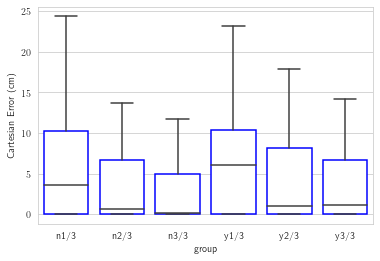

In [6]:
sns.set_style("whitegrid")
ax=sns.boxplot(y="Cartesian Error (cm)", x="group", data=dftest,showfliers=False)
for i in range(6):
    mybox=ax.artists[i]
    mybox.set_facecolor('white')
    mybox.set_edgecolor("blue")
plt.savefig('res1.pdf', dpi=300)    

In [41]:
F, p = stats.f_oneway(dftest.loc[dftest['group']=='n1/3',["Cartesian Error (cm)"]].append(dftest.loc[dftest['group']=='y1/3',["Cartesian Error (cm)"]])
                      ,dftest.loc[dftest['group']=='n2/3',["Cartesian Error (cm)"]].append(dftest.loc[dftest['group']=='y2/3',["Cartesian Error (cm)"]])
                     ,dftest.loc[dftest['group']=='n3/3',["Cartesian Error (cm)"]].append(dftest.loc[dftest['group']=='y3/3',["Cartesian Error (cm)"]]))
F_test = stats.f.ppf((1-0.05), 2, 297)

In [42]:
print(F,p,F_test)

[4.98426889] [0.00742837] 3.0261533685653728


In [37]:
dftest.groupby('group').describe()["Cartesian Error (cm)"]

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
n1/3,50.0,6.148520,6.735143,0.0,0.0,3.537297,10.210185,24.37062
n2/3,50.0,4.548810,6.087737,0.0,0.0,0.667119,6.637255,20.36015
n3/3,50.0,3.281641,5.776538,0.0,0.0,0.162361,4.959662,27.37684
y1/3,50.0,8.805271,16.265022,0.0,0.0,6.006906,10.364917,89.13267
y2/3,50.0,4.408834,5.406545,0.0,0.0,0.998966,8.141579,17.92162
y3/3,50.0,4.465018,6.237031,0.0,0.0,1.120592,6.614898,24.12812


In [6]:
df = dftest[dftest.noise=='n']

In [7]:
a1 = list(df[df.train=="13"]["distance after 1st motion (cm)"])
a2 = list(df[df.train=="23"]["distance after 1st motion (cm)"])
a3 = list(df[df.train=="33"]["distance after 1st motion (cm)"])
e1 = list(df[df.train=="13"]["Cartesian Error (cm)"])
e2 = list(df[df.train=="23"]["Cartesian Error (cm)"])
e3 = list(df[df.train=="33"]["Cartesian Error (cm)"])
n1 = list(df[df.train=="13"]["initial distance (cm)"])
n2 = list(df[df.train=="23"]["initial distance (cm)"])
n3 = list(df[df.train=="33"]["initial distance (cm)"])
d = a1+a2+a3+e1+e2+e3+n1+n2+n3
t = (50*['1/3']+50*['2/3']+50*['3/3'])*3
h = ["PTN"]*150+["PTN and DTN"]*150+["Neither"]*150

In [8]:
df = pd.DataFrame({"Average Cartesion Error(cm)":d, "Amount of Training": t, "Contribution":h})

In [49]:
F, p = stats.f_oneway(df.loc[df['Contribution']=='PTN',["Average Cartesion Error(cm)"]]
                      ,df.loc[df['Contribution']=='PTN and DTN',["Average Cartesion Error(cm)"]])
F_test = stats.f.ppf((1-0.05), 1, 298)

In [50]:
print(F,p,F_test)

[37.15421165] [3.37229652e-09] 3.8728528114631797


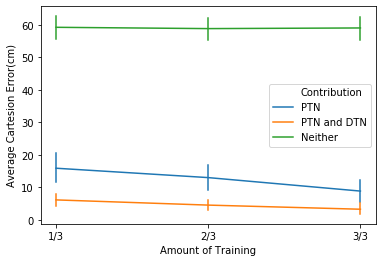

In [17]:
sns.lineplot(x="Amount of Training", y="Average Cartesion Error(cm)", hue="Contribution",data=df,markers=True,err_style="bars")
plt.savefig('res2.pdf', dpi=300) 

In [12]:
df[df["Amount of Training"]=='1/3'].groupby("Contribution").describe()["Average Cartesion Error(cm)"]

,count,mean,std,min,25%,50%,75%,max
Contribution,,,,,,,,
Neither,50.0,59.200000,12.910998,40.0,50.0,60.000000,70.000000,80.00000
PTN,50.0,15.885472,16.128677,0.0,0.0,12.919700,26.840697,49.49799
PTN and DTN,50.0,6.148520,6.735143,0.0,0.0,3.537297,10.210185,24.37062


In [51]:
df1 = pd.read_csv('testinfo_ang_n.csv')
df2 = pd.read_csv('testinfo_ang_r.csv')

In [52]:
a=[]
b=[]
for i in range(1,51):
    a.append(list(df1[df1.trial==i]['ang'])[-1])
    b.append(list(df2[df2.trial==i]['ang'])[-1])
df = pd.DataFrame({"Angular Difference (°)":a+b, "Contribution": ["Posture controller not involved"]*len(a)+["Posture controller involved"]*len(b)})    

In [53]:
F, p = stats.f_oneway(df.loc[df['Contribution']=="Posture controller not involved",["Angular Difference (°)"]]
                      ,df.loc[df['Contribution']=="Posture controller involved",["Angular Difference (°)"]])
F_test = stats.f.ppf((1-0.05), 1, 98)

In [54]:
print(F,p,F_test)

[55.75654955] [3.41497811e-11] 3.938111078003371


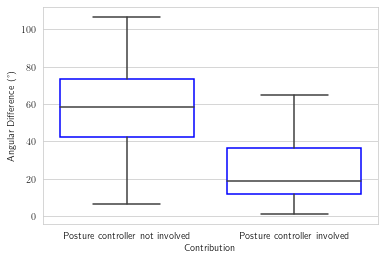

In [15]:
sns.set_style("whitegrid")
ax=sns.boxplot(y="Angular Difference (°)", x="Contribution", data=df,showfliers=False)
for i in range(2):
    mybox=ax.artists[i]
    mybox.set_facecolor('white')
    mybox.set_edgecolor("blue")
plt.savefig('res3.pdf', dpi=300)    

In [47]:
df.groupby("Contribution").describe()["Angular Difference (°)"]

,count,mean,std,min,25%,50%,75%,max
Contribution,,,,,,,,
Posture controller involved,50.0,25.490985,19.543245,1.163652,12.067258,18.625975,36.313965,84.73064
Posture controller not involved,50.0,57.203759,22.801946,6.796244,42.304645,58.356715,73.299310,106.69400
